In [1]:
import json
import pandas as pd
import numpy as np
import datetime
import helpers
import SessionSet
import model_evaluation
from importlib import reload
from model_evaluation import compute_generalization_error_estimate

In [2]:
reload(helpers)
json_data = json.load(open('./city_search.json'))
helpers.preprocess_json_for_pandas(json_data)
df = pd.io.json.json_normalize(json_data)
df['time_of_day'] = pd.Series(df['unix_timestamp'] % helpers.SECONDS_PER_DAY)
df['hour_of_day'] = pd.Series(df['time_of_day'] // helpers.SECONDS_PER_HOUR)
df['centered_hour'] = df.apply(helpers.to_GMT, axis=1)
df['session_date'] = df.apply(lambda row: datetime.datetime.utcfromtimestamp(row['unix_timestamp']), axis=1)
df['month'] = df.apply(lambda row: row['session_date'].month, axis=1)
df['day'] = df.apply(lambda row: row['session_date'].day, axis=1)
df['year'] = df.apply(lambda row: row['session_date'].year, axis=1)
df['join_month'] = df.apply(lambda row: row['user.joining_date'].split('-')[1], axis=1)
df['join_day'] = df.apply(lambda row: row['user.joining_date'].split('-')[2], axis=1)
df['request_count'] = df.apply(lambda row: len(row['cities']), axis=1)
df.replace('','??', inplace=True)
df.head()

,cities,session_id,unix_timestamp,user._row,user.country,user.joining_date,user.user_id,time_of_day,hour_of_day,centered_hour,session_date,month,day,year,join_month,join_day,request_count
0,"[new york ny, newark nj]",X061RFWB06K9V,1442503708,NaN,UK,2015-03-22,2024,55708,15,3,2015-09-17 15:28:28,9,17,2015,03,22,2
1,"[new york ny, jersey city nj, philadelphia pa]",5AZ2X2A9BHH5U,1441353991,NaN,DE,2015-03-28,2853,29191,8,-3,2015-09-04 08:06:31,9,4,2015,03,28,3
2,[san antonio tx],SHTB4IYAX4PX6,1440843490,NaN,UK,2015-03-06,10958,37090,10,-2,2015-08-29 10:18:10,8,29,2015,03,06,1
3,[edmonton ab],JBRB8MZGTX3M4,1427268063,NaN,IT,2015-03-12,7693,26463,7,-4,2015-03-25 07:21:03,3,25,2015,03,12,1
4,"[phoenix az, houston tx]",YJCMPURC2FL9C,1430559067,NaN,UK,2015-02-28,7506,34267,9,-3,2015-05-02 09:31:07,5,2,2015,02,28,2


In [3]:
reload(SessionSet)
reload(model_evaluation)
countries_sessions = {} 
time_summary_df = pd.DataFrame()
for country in set(df['user.country'].values):
    countries_sessions[country] = SessionSet.SessionSet(df.loc[df.loc[:,'user.country'] == country ,:], country)
    time_summary_df[country] = countries_sessions[country].get_time_metrics()
    print(country, countries_sessions[country].get_top_5_cities_with_precentage())
countries_sessions['ALL'] = SessionSet.SessionSet(df,'ALL')
print('ALL', countries_sessions['ALL'].get_top_5_cities_with_precentage())
time_summary_df['ALL'] = countries_sessions['ALL'].get_time_metrics()
time_summary_df = time_summary_df.T

DE [('new york ny', 0.2724024189114898), ('toronto on', 0.1657504123144585), ('los angeles ca', 0.12451896646509071), ('montreal qc', 0.12369433754810336), ('chicago il', 0.09785596481583288)]
UK [('new york ny', 0.270042194092827), ('toronto on', 0.16230661040787622), ('los angeles ca', 0.13473980309423347), ('montreal qc', 0.11645569620253164), ('chicago il', 0.09676511954992968)]
US [('new york ny', 0.26238390092879255), ('toronto on', 0.16615067079463364), ('los angeles ca', 0.13596491228070176), ('montreal qc', 0.10990712074303406), ('chicago il', 0.10036119711042311)]
FR [('new york ny', 0.2606614447345518), ('toronto on', 0.16405570060922542), ('los angeles ca', 0.13968668407310705), ('montreal qc', 0.1174934725848564), ('chicago il', 0.09704090513489991)]
IT [('new york ny', 0.27098831030818277), ('toronto on', 0.15621679064824653), ('los angeles ca', 0.14771519659936239), ('montreal qc', 0.1179596174282678), ('chicago il', 0.10626992561105207)]
?? [('new york ny', 0.2673758865

In [4]:
time_summary_df

,count,mean,std,min,25%,50%,75%,max
??,2820.0,6.580142,3.123955,0.0,4.0,7.0,9.0,16.0
DE,3638.0,10.987356,3.211002,2.0,8.0,11.0,13.0,20.0
US,3876.0,16.784830,5.731015,0.0,15.0,18.0,21.0,23.0
IT,1882.0,11.007970,3.281809,2.0,8.0,11.0,14.0,19.0
FR,2298.0,11.037424,3.183051,2.0,9.0,11.0,14.0,20.0
ES,1953.0,10.837686,3.183071,3.0,8.0,11.0,13.0,21.0
UK,3555.0,11.959212,3.215444,3.0,9.0,12.0,14.0,22.0
ALL,20022.0,11.654580,4.854823,0.0,8.0,11.0,15.0,23.0


In [74]:
month_sessions = {} 
for month in set(df['month'].values):
    month_sessions[month] = SessionSet.SessionSet(df.loc[df.loc[:,'month'] == month ,:], month)
    print(month, month_sessions[month].get_top_5_cities_with_precentage())
month_sessions['ALL'] = SessionSet.SessionSet(df,'ALL')
print('ALL', month_sessions['ALL'].get_top_5_cities_with_precentage())

2 [('new york ny', 0.5), ('los angeles ca', 0.5)]
3 [('new york ny', 0.26898326898326896), ('toronto on', 0.15444015444015444), ('los angeles ca', 0.12612612612612611), ('chicago il', 0.11518661518661519), ('montreal qc', 0.10553410553410554)]
4 [('new york ny', 0.27532894736842106), ('toronto on', 0.1611842105263158), ('los angeles ca', 0.13322368421052633), ('montreal qc', 0.11776315789473685), ('chicago il', 0.09802631578947368)]
5 [('new york ny', 0.2644395878863565), ('toronto on', 0.16453325007805183), ('los angeles ca', 0.1301904464564471), ('montreal qc', 0.1189509834530128), ('chicago il', 0.09959413050265377)]
6 [('new york ny', 0.2641826116146358), ('toronto on', 0.17220543806646527), ('los angeles ca', 0.1426653239342061), ('montreal qc', 0.11916750587445452), ('chicago il', 0.08794897616649883)]
7 [('new york ny', 0.27693303138142994), ('toronto on', 0.16628922678744743), ('los angeles ca', 0.13523131672597866), ('montreal qc', 0.1219670009705597), ('chicago il', 0.0980265

In [75]:
hour_sessions = {} 
for hour in set(df['centered_hour'].values):
    hour_sessions[hour] = SessionSet.SessionSet(df.loc[df.loc[:,'centered_hour'] == hour ,:], hour)
    print(hour, hour_sessions[hour].get_top_5_cities_with_precentage())
hour_sessions['ALL'] = SessionSet.SessionSet(df,'ALL')
print('ALL', hour_sessions['ALL'].get_top_5_cities_with_precentage())

0 [('new york ny', 0.2786234281932495), ('toronto on', 0.1628060886829914), ('montreal qc', 0.11250827266710788), ('los angeles ca', 0.11184645929847783), ('chicago il', 0.09794837855724686)]
1 [('new york ny', 0.26791277258566976), ('toronto on', 0.1588785046728972), ('los angeles ca', 0.14205607476635515), ('montreal qc', 0.11401869158878504), ('chicago il', 0.09968847352024922)]
2 [('new york ny', 0.2792475014697237), ('toronto on', 0.1646090534979424), ('los angeles ca', 0.13168724279835392), ('montreal qc', 0.11757789535567313), ('chicago il', 0.10170487948265726)]
3 [('new york ny', 0.266754270696452), ('toronto on', 0.16491458607095927), ('los angeles ca', 0.13863337713534823), ('montreal qc', 0.1116951379763469), ('chicago il', 0.09855453350854139)]
4 [('new york ny', 0.27384076990376205), ('toronto on', 0.1679790026246719), ('los angeles ca', 0.13123359580052493), ('montreal qc', 0.11198600174978128), ('chicago il', 0.10673665791776028)]
5 [('new york ny', 0.28169014084507044)

In [41]:
hour_sessions = {} 
for hour in set(df['join_day'].values):
    hour_sessions[hour] = SessionSet.SessionSet(df.loc[df.loc[:,'join_day'] == hour ,:], hour)
    print(hour, hour_sessions[hour].get_top_5_cities_with_precentage())
hour_sessions['ALL'] = SessionSet.SessionSet(df,'ALL')
print('ALL', hour_sessions['ALL'].get_top_5_cities_with_precentage())

22 [('new york ny', 0.24960505529225907), ('toronto on', 0.1674565560821485), ('los angeles ca', 0.13270142180094788), ('chicago il', 0.1263823064770932), ('montreal qc', 0.10426540284360189)]
11 [('new york ny', 0.2727272727272727), ('toronto on', 0.18181818181818182), ('los angeles ca', 0.12473572938689217), ('chicago il', 0.09936575052854123), ('montreal qc', 0.09725158562367865)]
21 [('new york ny', 0.25870646766169153), ('los angeles ca', 0.13805970149253732), ('toronto on', 0.1318407960199005), ('chicago il', 0.11567164179104478), ('montreal qc', 0.10696517412935323)]
19 [('new york ny', 0.3047619047619048), ('los angeles ca', 0.1619047619047619), ('toronto on', 0.14285714285714285), ('montreal qc', 0.11428571428571428), ('chicago il', 0.0761904761904762)]
09 [('new york ny', 0.26802507836990597), ('toronto on', 0.14890282131661442), ('los angeles ca', 0.14106583072100312), ('montreal qc', 0.12225705329153605), ('chicago il', 0.10031347962382445)]
29 [('new york ny', 0.2478991596

In [40]:
hour_sessions['ALL'].df.loc[:,'centered_hour'].value_counts()

-2     2060
-1     1959
-3     1862
 1     1822
 2     1816
 0     1784
 3     1622
-4     1465
 4     1334
-5     1008
 5      882
-6      625
-7      410
-8      304
 6      270
-9      180
-18     180
 7      107
-17     106
-10      88
-16      41
 8       38
-11      32
-15      11
 9        8
-14       3
-13       2
 10       2
-12       1
Name: centered_hour, dtype: int64

In [4]:
import model_evaluation
reload(model_evaluation)
#results = model_evaluation.compute_generalization_error_estimate(countries_sessions['ALL'], folds=3, repeats=10, stratification='user.country', top_x_cities=5, max_request_size_for_stats = 3)
#results_prior_only = model_evaluation.compute_generalization_error_estimate(countries_sessions['ALL'], folds=3, repeats=10, stratification='user.country', top_x_cities=5, max_request_size_for_stats = 3, ignore_coocurrences=True)
results_user_collapsed = model_evaluation.compute_generalization_error_estimate(
    countries_sessions['ALL'],
    folds=3,
    repeats=10,
    stratification='user.country',
    top_x_cities=5,
    max_request_size_for_stats = 3,
    aggregation=['user.user_id','month','day'])

/Users/andrewsutcliffe/Desktop/Data Analysis Challenge/BayesianModel.py:79: RuntimeWarning: divide by zero encountered in log
  X_cooccurence_probs = np.log(X_cooccurence_counts / X_total_counts)


fold: 0, repeat:0
fold: 1, repeat:0
fold: 2, repeat:0


/Users/andrewsutcliffe/Desktop/Data Analysis Challenge/BayesianModel.py:79: RuntimeWarning: divide by zero encountered in log
  X_cooccurence_probs = np.log(X_cooccurence_counts / X_total_counts)


fold: 0, repeat:1
fold: 1, repeat:1
fold: 2, repeat:1


/Users/andrewsutcliffe/Desktop/Data Analysis Challenge/BayesianModel.py:79: RuntimeWarning: divide by zero encountered in log
  X_cooccurence_probs = np.log(X_cooccurence_counts / X_total_counts)


fold: 0, repeat:2
fold: 1, repeat:2
fold: 2, repeat:2


/Users/andrewsutcliffe/Desktop/Data Analysis Challenge/BayesianModel.py:79: RuntimeWarning: divide by zero encountered in log
  X_cooccurence_probs = np.log(X_cooccurence_counts / X_total_counts)


fold: 0, repeat:3
fold: 1, repeat:3
fold: 2, repeat:3


/Users/andrewsutcliffe/Desktop/Data Analysis Challenge/BayesianModel.py:79: RuntimeWarning: divide by zero encountered in log
  X_cooccurence_probs = np.log(X_cooccurence_counts / X_total_counts)


fold: 0, repeat:4
fold: 1, repeat:4
fold: 2, repeat:4


/Users/andrewsutcliffe/Desktop/Data Analysis Challenge/BayesianModel.py:79: RuntimeWarning: divide by zero encountered in log
  X_cooccurence_probs = np.log(X_cooccurence_counts / X_total_counts)


fold: 0, repeat:5
fold: 1, repeat:5
fold: 2, repeat:5


/Users/andrewsutcliffe/Desktop/Data Analysis Challenge/BayesianModel.py:79: RuntimeWarning: divide by zero encountered in log
  X_cooccurence_probs = np.log(X_cooccurence_counts / X_total_counts)


fold: 0, repeat:6
fold: 1, repeat:6
fold: 2, repeat:6


/Users/andrewsutcliffe/Desktop/Data Analysis Challenge/BayesianModel.py:79: RuntimeWarning: divide by zero encountered in log
  X_cooccurence_probs = np.log(X_cooccurence_counts / X_total_counts)


fold: 0, repeat:7
fold: 1, repeat:7
fold: 2, repeat:7


/Users/andrewsutcliffe/Desktop/Data Analysis Challenge/BayesianModel.py:79: RuntimeWarning: divide by zero encountered in log
  X_cooccurence_probs = np.log(X_cooccurence_counts / X_total_counts)


fold: 0, repeat:8
fold: 1, repeat:8
fold: 2, repeat:8


/Users/andrewsutcliffe/Desktop/Data Analysis Challenge/BayesianModel.py:79: RuntimeWarning: divide by zero encountered in log
  X_cooccurence_probs = np.log(X_cooccurence_counts / X_total_counts)


fold: 0, repeat:9
fold: 1, repeat:9
fold: 2, repeat:9


In [7]:
np.mean(np.sum(results_user_collapsed['data'], axis=2),axis=0)

array([0.23595557, 0.35127853, 0.44706331, 0.52334949, 0.59178409])

In [71]:
#results['mean']

array([[0.21349164, 0.09056788, 0.30946829, 0.39407684],
       [0.33230988, 0.18606978, 0.49435687, 0.62200048],
       [0.43277733, 0.31290283, 0.64770274, 0.77140687],
       [0.51872252, 0.3980438 , 0.79805477, 0.81878426],
       [0.58666083, 0.51204176, 0.84928747, 0.85045594]])

In [72]:
#PREV: results_prior_only['mean'] 

array([[0.21346273, 0.19664133, 0.10935082, 0.06278971],
       [0.33227385, 0.3167888 , 0.17986601, 0.10199649],
       [0.43274533, 0.41074621, 0.2451387 , 0.14476015],
       [0.51867195, 0.49588376, 0.27978138, 0.15469626],
       [0.58661385, 0.55457949, 0.31202091, 0.17745188]])

In [6]:
#Just User: results_user_collapsed['mean']

array([[0.21348239, 0.24571941, 0.2206492 , 0.15197001],
       [0.33230976, 0.3430128 , 0.30119033, 0.23183832],
       [0.43276234, 0.42198994, 0.36766237, 0.31372084],
       [0.51869914, 0.48634587, 0.4467084 , 0.386651  ],
       [0.58664246, 0.53393366, 0.51286742, 0.44249425]])

In [6]:
#User Month: results_user_collapsed['mean']

array([[0.21347934, 0.24344068, 0.31491471, 0.30937246],
       [0.33230228, 0.35296295, 0.43171044, 0.42453221],
       [0.43274955, 0.44732842, 0.51392102, 0.49857412],
       [0.51867572, 0.51715839, 0.5653766 , 0.55265798],
       [0.58663468, 0.59597419, 0.60427847, 0.59867871]])

In [5]:
results_user_collapsed['mean']

array([[0.21348273, 0.15850314, 0.27583789, 0.32436292],
       [0.33230901, 0.22878037, 0.41308411, 0.51062639],
       [0.43276944, 0.30403161, 0.51136891, 0.63604813],
       [0.5187038 , 0.39801853, 0.59741292, 0.72490651],
       [0.58664158, 0.46238943, 0.66859835, 0.7721147 ]])

In [7]:
np.mean(results_user_collapsed['tracker'], axis = 0)

array([[0.53296391, 0.34492042, 0.08086102, 0.04125466]])

In [64]:
np.mean(results['tracker'], axis = 0)

array([[0.53296358, 0.34492066, 0.08086103, 0.04125473]])

In [159]:
diag = np.diag(log_proba.values)
sequence = ['toledo oh']
ll = np.zeros((1,89))
for city in sequence:
    ll = ll + log_proba.loc[city].values
ll += max(len(sequence),1) * diag
ll = ll * -1
def ciy_to_index(i):
    return list(city_index_mapping.keys())[i]

ordered_list = list(map(ciy_to_index, np.argsort(ll.flatten())))
print(next(city for city in ordered_list if city not in sequence))

windsor on


In [21]:
np.std(results/tracker, axis=0)

array([[0.00822666, 0.01018817, 0.02419959, 0.04166754],
       [0.00762942, 0.0117362 , 0.02116525, 0.03461666],
       [0.00847193, 0.01394905, 0.02214446, 0.02671643]])

In [30]:
reload(helpers)
user_origins = helpers.compute_user_origin_matrix(countries_sessions)
user_origins

,ES,UK,US,??,FR,DE,IT,ALL
ES,569.0,0.0,0.0,0.0,0.0,0.0,0.0,569.0
UK,0.0,1043.0,0.0,0.0,0.0,0.0,0.0,1043.0
US,0.0,0.0,1129.0,0.0,0.0,0.0,0.0,1129.0
??,0.0,0.0,0.0,792.0,0.0,0.0,0.0,792.0
FR,0.0,0.0,0.0,0.0,665.0,0.0,0.0,665.0
DE,0.0,0.0,0.0,0.0,0.0,1051.0,0.0,1051.0
IT,0.0,0.0,0.0,0.0,0.0,0.0,528.0,528.0
ALL,569.0,1043.0,1129.0,792.0,665.0,1051.0,528.0,5777.0


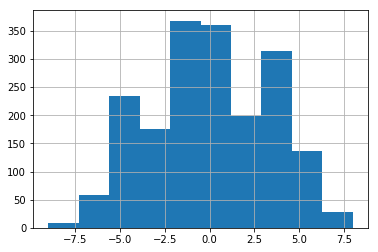

In [49]:
(countries_sessions['IT'].df['centered_hour']).hist()

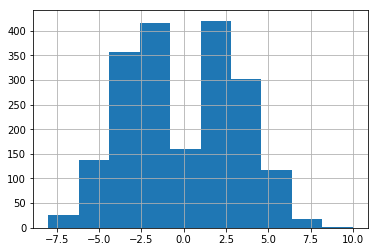

In [50]:
(countries_sessions['ES'].df['centered_hour']).hist()

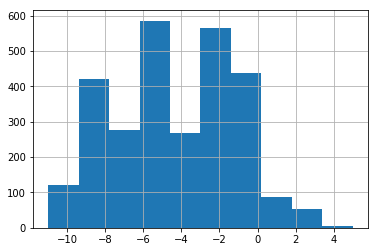

In [61]:
(countries_sessions['??'].df['centered_hour']).hist()

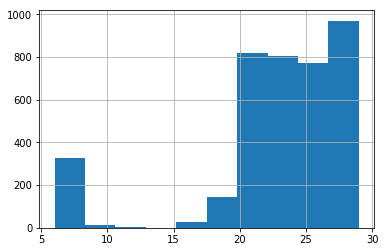

In [58]:
(countries_sessions['US'].df['centered_hour']).hist()